In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import seaborn as sns


# Chapter 18 examples

In [4]:
climbers = pd.read_csv("climbers.csv")
climbers.head()

,expedition_id,member_id,success,year,season,age,expedition_role,oxygen_used
0,AMAD81101,AMAD81101-03,True,1981,Spring,28,Climber,False
1,AMAD81101,AMAD81101-04,True,1981,Spring,27,Exp Doctor,False
2,AMAD81101,AMAD81101-02,True,1981,Spring,35,Deputy Leader,False
3,AMAD81101,AMAD81101-05,True,1981,Spring,37,Climber,False
4,AMAD81101,AMAD81101-06,True,1981,Spring,43,Climber,False


In [5]:

total = climbers.shape[0]
climbers[['success','member_id']].groupby('success').count().assign(percent = lambda x: x.member_id/total).rename(columns = {'member_id':'count'})

,count,percent
success,,
False,1269,0.611272
True,807,0.388728


Binomial model

In [35]:
model1 = bmb.Model('success ~ age + oxygen_used + (1|expedition_id)',data = climbers, family="bernoulli")
model1.build()
model1

Formula: success ~ age + oxygen_used + (1|expedition_id)
Family name: Bernoulli
Link: logit
Observations: 2076
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 9.3311)
    age ~ Normal(mu: 0.0, sigma: 0.2394)
    oxygen_used ~ Normal(mu: 0.0, sigma: 5.5123)

  Group-level effects
    1|expedition_id ~ Normal(mu: 0, sigma: HalfNormal(sigma: 9.3311))

In [36]:
results = model1.fit()
az.summary(results, hdi_prob=0.8)

Modeling the probability that success==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, oxygen_used, 1|expedition_id_sigma, 1|expedition_id_offset]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.502,0.495,-2.456,-0.619,0.014,0.010,1186.0,1908.0,1.0
age,-0.048,0.009,-0.065,-0.030,0.000,0.000,5191.0,3267.0,1.0
oxygen_used,5.903,0.500,4.963,6.819,0.013,0.009,1467.0,2161.0,1.0
1|expedition_id_sigma,3.755,0.370,3.071,4.443,0.012,0.008,982.0,1788.0,1.0
1|expedition_id[AMAD03107],2.670,1.079,0.496,4.558,0.020,0.014,2840.0,2569.0,1.0
...,...,...,...,...,...,...,...,...,...
1|expedition_id[TILI91302],1.765,0.933,0.031,3.440,0.019,0.013,2442.0,2196.0,1.0
1|expedition_id[TILI92301],-2.745,2.405,-7.255,1.303,0.041,0.034,4194.0,2836.0,1.0
1|expedition_id[TKPO02102],-2.714,2.413,-7.423,1.175,0.039,0.033,4378.0,2876.0,1.0
1|expedition_id[TUKU05101],-2.285,2.617,-7.202,2.334,0.040,0.035,4846.0,2966.0,1.0


In [53]:
model1.predict(results,kind='pps')
post_pred = results.posterior_predictive.to_dataframe().reset_index()

Each draw contains a prediction now for each of the climbers.  We can use this to manually check that the results make sense

<AxesSubplot:>

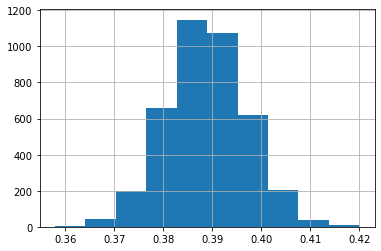

In [55]:
post_pred.groupby(['chain','draw']).mean()['success'].hist()

Also would like to check that the accuracy.  Keep in mind that we have 2076 predictions for each draw. Below is the predicted probability of success for the first climber. This climber did succeed. 

In [77]:
post_pred.head()

,chain,draw,success_dim_0,success
0,0,0,0,1
1,0,0,1,1
2,0,0,2,1
3,0,0,3,1
4,0,0,4,1


In [74]:
climbers['pred_prob'] = post_pred.groupby('success_dim_0').mean()['success']
climbers.head()

,expedition_id,member_id,success,year,season,age,expedition_role,oxygen_used,pred_prob
0,AMAD81101,AMAD81101-03,True,1981,Spring,28,Climber,False,0.84075
1,AMAD81101,AMAD81101-04,True,1981,Spring,27,Exp Doctor,False,0.84650
2,AMAD81101,AMAD81101-02,True,1981,Spring,35,Deputy Leader,False,0.79250
3,AMAD81101,AMAD81101-05,True,1981,Spring,37,Climber,False,0.77550
4,AMAD81101,AMAD81101-06,True,1981,Spring,43,Climber,False,0.73375


In [76]:
climbers['pred_success'] = climbers.pred_prob > 0.5
(climbers['pred_success'] == climbers['success']).mean()

0.9157032755298651

So the model is 91.6% accurate at predicting on the TEST data. 

### Posterior median model (fig 18.4)
 I think for this we *could* use the 'ignore group effects' posterior prediction, because that does seem to be what the book is plotting, and I can see how it could be considered relavevent.  I could use new_data for this with a range of ages, and possibly use az.plot_hdi. But i think it is much much easier to simply use the logit link and compute directly. 

### verifying prediction of row one

In [62]:
temp = model1.predict(results,kind='pps', data = pd.DataFrame({'age' : [28], 'oxygen_used' : 0, 'expedition_id' :'AMAD81101' }),inplace=False)

In [63]:
temp.posterior_predictive.to_dataframe()['success'].mean()

0.83375

To do the 4 climbers on a new expedition, we have to do it manually, which is fine.  Just chose any expedition and grab all the group level effects

In [84]:
post_df_new = results.posterior.to_dataframe().query("expedition_id__factor_dim == 'AMAD03107'").reset_index()[['Intercept','age','oxygen_used','1|expedition_id_sigma']]
post_df_new

,Intercept,age,oxygen_used,1|expedition_id_sigma
0,-1.011424,-0.059907,6.187956,3.779178
1,-1.211941,-0.058411,6.400901,4.117817
2,-1.938324,-0.036875,5.719473,3.453481
3,-1.113213,-0.051222,6.030923,3.500494
4,-1.538789,-0.047257,5.865151,3.487213
...,...,...,...,...
3995,-1.366546,-0.044234,5.594293,3.474164
3996,-1.689224,-0.055159,6.477721,3.722529
3997,-1.397711,-0.056377,6.087543,3.505629
3998,-2.122478,-0.040731,6.059484,3.605083


These are the samples I need to compute new predictions for a new group. 